In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/xAPI-Edu-Data/xAPI-Edu-Data.csv


# 一、数据载入

In [2]:
import pandas as pd 

edu_df = pd.read_csv('/kaggle/input/xAPI-Edu-Data/xAPI-Edu-Data.csv')
edu_df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [3]:
edu_df.keys()

Index(['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID',
       'SectionID', 'Topic', 'Semester', 'Relation', 'raisedhands',
       'VisITedResources', 'AnnouncementsView', 'Discussion',
       'ParentAnsweringSurvey', 'ParentschoolSatisfaction',
       'StudentAbsenceDays', 'Class'],
      dtype='object')

# 二、家长参与特征（Parents Participation on learning process）初步统计与分析
1. **家长参与特征包括**：
    * 问卷调查参与情况(Parent Answering Survey): 家长是否参与学校的问卷调查，数据中对应key为'ParentAnsweringSurvey'
    * 满意程度(Parent School Satisfaction): 家长对学校的满意程度，数据中对应key为'ParentschoolSatisfaction'
2. **与家长相关的特征**：
    * 负责学生的家长(Parent responsible for student): 数据中对应key为'Relation'
3. **初步分析以下内容**:
    * 问卷调查参与情况('ParentAnsweringSurvey')与以下属性的关系
        - 学生表现(’Class‘)
        - 学生逃课次数('StudentAbsenceDays')
    * 满意程度('ParentschoolSatisfaction')与以下属性的关系
        - 学生表现(’Class‘)
        - 学生逃课次数('StudentAbsenceDays')
    * 负责学生的家长('Relation')与以下属性的关系
        - 学生表现(’Class‘)
        - 学生逃课次数('StudentAbsenceDays')
    * 三个家长相关特征间的关系

## 1. 问卷调查特征

从下方的简单统计结果可以观察到：
1. 家长参加问卷调查与学生的表现成正相关。家长参与填写问卷，学生的成绩相对更好
2. 家长参与问卷调查与学生出勤情况有轻微的负相关 （因为lift值略小于1）

In [4]:
pd.crosstab(edu_df['ParentAnsweringSurvey'],edu_df['Class'])

Class,H,L,M
ParentAnsweringSurvey,,,
No,28,99,83
Yes,114,28,128


In [5]:
cross_table = pd.crosstab(edu_df['ParentAnsweringSurvey'],edu_df['StudentAbsenceDays'])
cross_table

StudentAbsenceDays,Above-7,Under-7
ParentAnsweringSurvey,,
No,114,96
Yes,77,193


In [6]:
# 计算ParentAnsweringSurvey和StudentAbsenceDays的lift值
total = cross_table.sum().sum()

lift_score = cross_table['Above-7']['Yes']/total / (cross_table['Above-7'].sum()/total * (cross_table['Above-7']['Yes']+cross_table['Under-7']['Yes']) / total)
print('lift({})={:.3f}'.format('Above-7, Yes', lift_score))

lift(Above-7, Yes)=0.717


## 2. 满意程度特征

数据反应出的相关关系与直觉相符合：
1. 家长满意程度与表现呈明显的正相关，即学生成绩越好家长越满意
2. 家长满意程度与学生缺勤情况呈明显的负相关，即学生缺勤越少家长越满意

In [7]:
pd.crosstab(edu_df['ParentschoolSatisfaction'],edu_df['Class'])

Class,H,L,M
ParentschoolSatisfaction,,,
Bad,24,84,80
Good,118,43,131


In [8]:
pd.crosstab(edu_df['ParentschoolSatisfaction'],edu_df['StudentAbsenceDays'])

StudentAbsenceDays,Above-7,Under-7
ParentschoolSatisfaction,,
Bad,101,87
Good,90,202


## 3. 负责家长属性

从数据中可以发现：
1. 母亲负责的学生其对应表现大多好于父亲负责的学生
2. 母亲负责的学生对应的出勤情况大多好于父亲负责的学生**

In [9]:
pd.crosstab(edu_df['Relation'],edu_df['Class'])

Class,H,L,M
Relation,,,
Father,42,104,137
Mum,100,23,74


In [10]:
pd.crosstab(edu_df['Relation'],edu_df['StudentAbsenceDays'])

StudentAbsenceDays,Above-7,Under-7
Relation,,
Father,138,145
Mum,53,144


## 4. 三个家长相关特征间的关系

从数据中可以初步看到

1. 参与调查问卷与满意度呈正比
2. 父亲们在参与意见调查问题上并没有明显的倾向，而母亲们更倾向于参与意见调查
3. 母亲们相对于父亲们对学校教育更满意（这很可能是因为母亲所负责的学生表现更好）

In [11]:
pd.crosstab(edu_df['ParentAnsweringSurvey'],edu_df['ParentschoolSatisfaction'])

ParentschoolSatisfaction,Bad,Good
ParentAnsweringSurvey,,
No,145,65
Yes,43,227


In [12]:
pd.crosstab(edu_df['Relation'],edu_df['ParentAnsweringSurvey'])

ParentAnsweringSurvey,No,Yes
Relation,,
Father,143,140
Mum,67,130


In [13]:
pd.crosstab(edu_df['Relation'],edu_df['ParentschoolSatisfaction'])

ParentschoolSatisfaction,Bad,Good
Relation,,
Father,144,139
Mum,44,153


# 三、深入分析

**对于学生的学习表现，父母具体参方（父亲或母亲）与父母参与的方式（是否参与问卷调查）哪一属性更为重要？**

1. 基于机器学习
    * 剔除相应的特征对logistics regression分类性能的影响
    * decision tree对应节点位置的比较 

## 单独观察父亲或母亲参与问卷调查('ParentAnsweringSurvey')和学生表现('Class')的关系

从数据中可以观察到，所有父亲（或母亲）中参与调查问卷与学生的成绩成正相关

In [14]:
# 仅包含父亲的子表
father_sub_df = edu_df.loc[edu_df['Relation']=='Father']

In [15]:
pd.crosstab(father_sub_df['ParentAnsweringSurvey'],father_sub_df['Class'])

Class,H,L,M
ParentAnsweringSurvey,,,
No,6,80,57
Yes,36,24,80


In [16]:
# 仅包含母亲的子表
mother_sub_df = edu_df.loc[edu_df['Relation']=='Mum']

In [17]:
pd.crosstab(mother_sub_df['ParentAnsweringSurvey'],mother_sub_df['Class'])

Class,H,L,M
ParentAnsweringSurvey,,,
No,22,19,26
Yes,78,4,48


## logistic regression

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

RANDOM_STATE = 42

In [19]:
def get_features_and_target(df, features_to_use, target_key='Class'):
    
    assert target_key not in features_to_use, 'target labels should not be a part of features'
    
    target = df[target_key]
    features = df[features_to_use]
    
    label_encoder = LabelEncoder()
    cat_colums = features.dtypes.pipe(lambda features: features[features=='object']).index
    for col in cat_colums:
        label_encoder.fit(features[col])
        print('>>> Mapping')
        print({k:v for k, v in zip(label_encoder.classes_, range(len(label_encoder.classes_)))})
        features.loc[:, col] = label_encoder.transform(features[col])
    
    label_encoder.fit(target)
    print('>>> Mapping')
    print({k:v for k, v in zip(label_encoder.classes_, range(len(label_encoder.classes_)))})
    target = label_encoder.transform(target)
    
    return features, target    

In [20]:
def k_fold_logistic(features, target, total_exp_num, k_fold, max_iter, rand_state=42):
    # 10 fold validation

    all_scores = list()

    for i in range(total_exp_num):
        kf = KFold(n_splits=k_fold, shuffle=True)
        for j, (train_idx, test_idx) in enumerate(kf.split(features, target)):
            k_X_train = features.values[train_idx]
            k_y_train = target[train_idx]
            k_X_test = features.values[test_idx]
            k_y_test = target[test_idx]

            clf = LogisticRegression(solver='lbfgs', multi_class='multinomial',max_iter=max_iter, random_state=rand_state+i)
            clf.fit(k_X_train,k_y_train)
            k_prediction = clf.predict(k_X_test)
            k_score = accuracy_score(k_y_test, k_prediction)

            all_scores.append(k_score) 
    print("Accuracy: {:.2f} (+/- {:.2f})".format(np.mean(all_scores), np.std(all_scores) * 2))

## 同时使用所有家长相关特征分类

In [21]:
# 特征选择
LOGISTIC_FEATURE_TO_USE = ['gender', 'Relation', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction']
features, target = get_features_and_target(edu_df, LOGISTIC_FEATURE_TO_USE, target_key='Class')

>>> Mapping
{'F': 0, 'M': 1}
>>> Mapping
{'Father': 0, 'Mum': 1}
>>> Mapping
{'HighSchool': 0, 'MiddleSchool': 1, 'lowerlevel': 2}
>>> Mapping
{'Arabic': 0, 'Biology': 1, 'Chemistry': 2, 'English': 3, 'French': 4, 'Geology': 5, 'History': 6, 'IT': 7, 'Math': 8, 'Quran': 9, 'Science': 10, 'Spanish': 11}
>>> Mapping
{'Above-7': 0, 'Under-7': 1}
>>> Mapping
{'No': 0, 'Yes': 1}
>>> Mapping
{'Bad': 0, 'Good': 1}
>>> Mapping
{'H': 0, 'L': 1, 'M': 2}


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
print(LOGISTIC_FEATURE_TO_USE)
k_fold_logistic(features, target, total_exp_num=10, k_fold=10, max_iter=5000, rand_state=RANDOM_STATE)

['gender', 'Relation', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction']
Accuracy: 0.69 (+/- 0.11)


## 剔除问卷调查参与分类

In [23]:
LOGISTIC_FEATURE_TO_USE = ['gender', 'Relation', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentschoolSatisfaction']

features, target = get_features_and_target(edu_df, LOGISTIC_FEATURE_TO_USE, target_key='Class')

>>> Mapping
{'F': 0, 'M': 1}
>>> Mapping
{'Father': 0, 'Mum': 1}
>>> Mapping
{'HighSchool': 0, 'MiddleSchool': 1, 'lowerlevel': 2}
>>> Mapping
{'Arabic': 0, 'Biology': 1, 'Chemistry': 2, 'English': 3, 'French': 4, 'Geology': 5, 'History': 6, 'IT': 7, 'Math': 8, 'Quran': 9, 'Science': 10, 'Spanish': 11}
>>> Mapping
{'Above-7': 0, 'Under-7': 1}
>>> Mapping
{'Bad': 0, 'Good': 1}
>>> Mapping
{'H': 0, 'L': 1, 'M': 2}


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
print(LOGISTIC_FEATURE_TO_USE)
k_fold_logistic(features, target, total_exp_num=10, k_fold=10, max_iter=5000, rand_state=RANDOM_STATE)

['gender', 'Relation', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentschoolSatisfaction']
Accuracy: 0.64 (+/- 0.13)


## 剔除满意程度参与分类

In [25]:
LOGISTIC_FEATURE_TO_USE = ['gender', 'Relation', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentAnsweringSurvey']

features, target = get_features_and_target(edu_df, LOGISTIC_FEATURE_TO_USE, target_key='Class')

>>> Mapping
{'F': 0, 'M': 1}
>>> Mapping
{'Father': 0, 'Mum': 1}
>>> Mapping
{'HighSchool': 0, 'MiddleSchool': 1, 'lowerlevel': 2}
>>> Mapping
{'Arabic': 0, 'Biology': 1, 'Chemistry': 2, 'English': 3, 'French': 4, 'Geology': 5, 'History': 6, 'IT': 7, 'Math': 8, 'Quran': 9, 'Science': 10, 'Spanish': 11}
>>> Mapping
{'Above-7': 0, 'Under-7': 1}
>>> Mapping
{'No': 0, 'Yes': 1}
>>> Mapping
{'H': 0, 'L': 1, 'M': 2}


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [26]:
print(LOGISTIC_FEATURE_TO_USE)
k_fold_logistic(features, target, total_exp_num=10, k_fold=10, max_iter=5000, rand_state=RANDOM_STATE)

['gender', 'Relation', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentAnsweringSurvey']
Accuracy: 0.70 (+/- 0.13)


## 剔除家长参与分类

In [27]:
LOGISTIC_FEATURE_TO_USE = ['gender', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction']

features, target = get_features_and_target(edu_df, LOGISTIC_FEATURE_TO_USE, target_key='Class')

>>> Mapping
{'F': 0, 'M': 1}
>>> Mapping
{'HighSchool': 0, 'MiddleSchool': 1, 'lowerlevel': 2}
>>> Mapping
{'Arabic': 0, 'Biology': 1, 'Chemistry': 2, 'English': 3, 'French': 4, 'Geology': 5, 'History': 6, 'IT': 7, 'Math': 8, 'Quran': 9, 'Science': 10, 'Spanish': 11}
>>> Mapping
{'Above-7': 0, 'Under-7': 1}
>>> Mapping
{'No': 0, 'Yes': 1}
>>> Mapping
{'Bad': 0, 'Good': 1}
>>> Mapping
{'H': 0, 'L': 1, 'M': 2}


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [28]:
print(LOGISTIC_FEATURE_TO_USE)
k_fold_logistic(features, target, total_exp_num=10, k_fold=10, max_iter=5000, rand_state=RANDOM_STATE)

['gender', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction']
Accuracy: 0.64 (+/- 0.10)


## Decision Tree

In [29]:
from sklearn import tree

RAND_STATE = 42

In [30]:
DT_FEATURE_TO_USE = ['gender', 'Relation', 'StageID', 'Topic', 'StudentAbsenceDays', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction']
features, target = get_features_and_target(edu_df, DT_FEATURE_TO_USE, target_key='Class')

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=RAND_STATE)

dt = tree.DecisionTreeClassifier(max_depth=4)
dt = dt.fit(X_train, y_train)

>>> Mapping
{'F': 0, 'M': 1}
>>> Mapping
{'Father': 0, 'Mum': 1}
>>> Mapping
{'HighSchool': 0, 'MiddleSchool': 1, 'lowerlevel': 2}
>>> Mapping
{'Arabic': 0, 'Biology': 1, 'Chemistry': 2, 'English': 3, 'French': 4, 'Geology': 5, 'History': 6, 'IT': 7, 'Math': 8, 'Quran': 9, 'Science': 10, 'Spanish': 11}
>>> Mapping
{'Above-7': 0, 'Under-7': 1}
>>> Mapping
{'No': 0, 'Yes': 1}
>>> Mapping
{'Bad': 0, 'Good': 1}
>>> Mapping
{'H': 0, 'L': 1, 'M': 2}


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[Text(167.4, 195.696, 'X[4] <= 0.5\ngini = 0.652\nsamples = 360\nvalue = [114, 93, 153]'),
 Text(83.7, 152.208, 'X[5] <= 0.5\ngini = 0.485\nsamples = 133\nvalue = [3, 83, 47]'),
 Text(41.85, 108.72, 'X[3] <= 6.5\ngini = 0.307\nsamples = 86\nvalue = [1, 70, 15]'),
 Text(20.925, 65.232, 'X[3] <= 0.5\ngini = 0.184\nsamples = 39\nvalue = [0, 35, 4]'),
 Text(10.4625, 21.744, 'gini = 0.0\nsamples = 10\nvalue = [0, 10, 0]'),
 Text(31.387500000000003, 21.744, 'gini = 0.238\nsamples = 29\nvalue = [0, 25, 4]'),
 Text(62.775000000000006, 65.232, 'X[1] <= 0.5\ngini = 0.39\nsamples = 47\nvalue = [1, 35, 11]'),
 Text(52.3125, 21.744, 'gini = 0.331\nsamples = 43\nvalue = [0, 34, 9]'),
 Text(73.2375, 21.744, 'gini = 0.625\nsamples = 4\nvalue = [1, 1, 2]'),
 Text(125.55000000000001, 108.72, 'X[3] <= 6.5\ngini = 0.458\nsamples = 47\nvalue = [2, 13, 32]'),
 Text(104.625, 65.232, 'X[3] <= 2.5\ngini = 0.381\nsamples = 25\nvalue = [1, 5, 19]'),
 Text(94.16250000000001, 21.744, 'gini = 0.556\nsamples = 13\nv

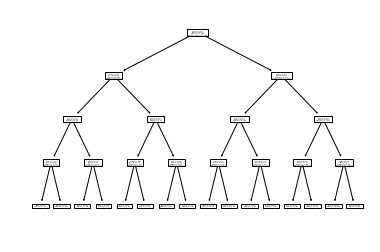

In [31]:
tree.plot_tree(dt) 

In [32]:
import graphviz

dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render("Edu Dataset")

dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=DT_FEATURE_TO_USE,  
                                class_names=['H', 'L', 'M'],  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = graphviz.Source(dot_data) 

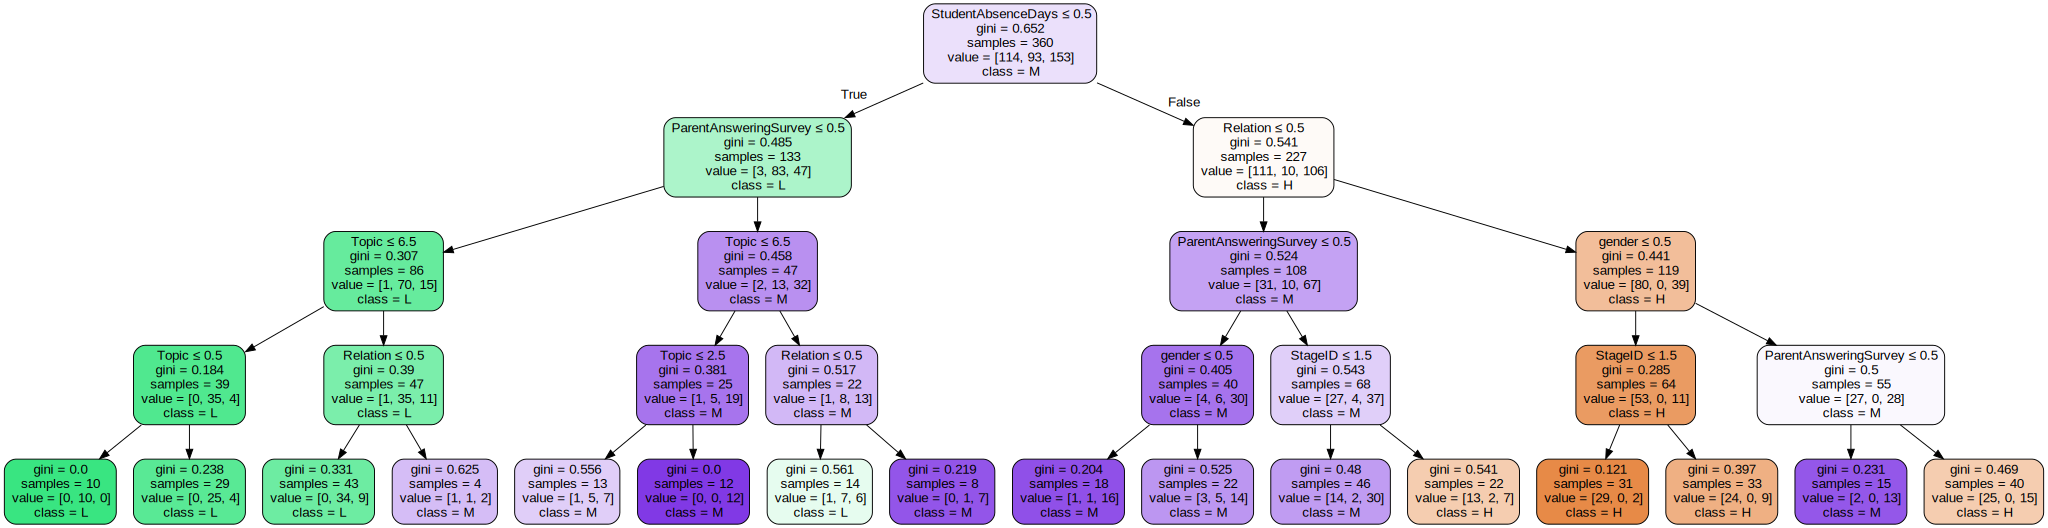

In [33]:
graph

In [34]:
from sklearn.tree.export import export_text

r = export_text(dt, feature_names=DT_FEATURE_TO_USE)
print(r)

|--- StudentAbsenceDays <= 0.50
|   |--- ParentAnsweringSurvey <= 0.50
|   |   |--- Topic <= 6.50
|   |   |   |--- Topic <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Topic >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Topic >  6.50
|   |   |   |--- Relation <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Relation >  0.50
|   |   |   |   |--- class: 2
|   |--- ParentAnsweringSurvey >  0.50
|   |   |--- Topic <= 6.50
|   |   |   |--- Topic <= 2.50
|   |   |   |   |--- class: 2
|   |   |   |--- Topic >  2.50
|   |   |   |   |--- class: 2
|   |   |--- Topic >  6.50
|   |   |   |--- Relation <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Relation >  0.50
|   |   |   |   |--- class: 2
|--- StudentAbsenceDays >  0.50
|   |--- Relation <= 0.50
|   |   |--- ParentAnsweringSurvey <= 0.50
|   |   |   |--- gender <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- gender >  0.50
|   |   |   |   |--- class: 2
|   |   |--- ParentAnsweringSurvey >  0.50
|   |   |   |-

In [35]:
pred = dt.predict(X_test)
score = accuracy_score(y_test,pred)
report = classification_report(y_test,pred)
print('==== acc ====')
print(score)
print('==== report ====')
print(report)

==== acc ====
0.7333333333333333
==== report ====
              precision    recall  f1-score   support

           0       0.60      0.64      0.62        28
           1       0.80      0.94      0.86        34
           2       0.76      0.66      0.70        58

    accuracy                           0.73       120
   macro avg       0.72      0.75      0.73       120
weighted avg       0.73      0.73      0.73       120



### 总结

1. 从logistic回归可以看到，剔除父母问卷调查参与度与父母具体负责人都对分类结果有着相同程度的影响。这说明两者对于学生最终表现的影响差异不大。
2. 决策树进一步阐述了两者的影响，当学生自身不努力（缺勤程度较高时）父母问卷参与调查显得尤为重要，参与问卷后学生成绩普遍能达到'M'而不是'L'。当学生自身努力时，母亲的参与能为孩子提供助力，学生成绩普遍是'H'。